**The implementation in this notebook is based on the model described in** <br />
Kunang, Y. N., Nurmaini, S., Stiawan, D., & Suprapto, B. Y. (2021). Attack classification of an intrusion detection system using deep learning and hyperparameter optimization. *Journal of Information Security and Applications*, *58*, 102804. https://doi.org/10.1016/j.jisa.2021.102804

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# NSL-KDD

### List of attributes

In [5]:
attributes = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack_type','classifiers'
]

## Training Set

### KDDTrain+.txt
header = None is used since the first line in the .txt file is a record (a feature vector) <br />
index_col = False is used to avoid the automatic use of the first column as an index

In [6]:
train_set = pd.read_csv('KDDTrain+.txt', header = None, index_col = False, names = attributes)

services = train_set['service'].unique()
flags = train_set['flag'].unique()
protocols = train_set['protocol_type'].unique()

### KDDTrain+_20Percent.txt

In [7]:
train_set_20 = pd.read_csv('KDDTrain+_20Percent.txt', header = None, index_col = False, names = attributes)

## Test Sets

### KDDTest+.txt

In [8]:
test_set = pd.read_csv('KDDTest+.txt', header = None, index_col = False, names = attributes)

### KDDTest-21.txt

In [9]:
test_set_21 = pd.read_csv('KDDTest-21.txt', header = None, index_col = False, names = attributes)

# Data Inspection

In [10]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df.isnull().sum().sum())

0
0
0
0


There are no missing values in the dataset

In [11]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    for col in attributes:
        if(df[col].nunique()<2):
            print(col)

num_outbound_cmds
num_outbound_cmds
is_host_login
num_outbound_cmds
num_outbound_cmds


In [12]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['num_outbound_cmds'].unique())

[0]
[0]
[0]
[0]


In [13]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['service'].nunique())

70
66
64
62


In [14]:
for df in [train_set_20, test_set, test_set_21]:
    isTrue = np.isin(df['service'].unique(), services)
    print((isTrue == True).all())

True
True
True


The service values are the same accross the entire dataset. **However**, KDDTrain20Percent and both train datasets do not have all the services which will cause a problem in encoding

In [15]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['flag'].nunique())

11
11
11
11


In [16]:
for df in [train_set_20, test_set, test_set_21]:
    isTrue = np.isin(df['flag'].unique(), flags)
    print((isTrue == True).all())

True
True
True


The flag values are the same accross the entire dataset.

In [17]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['protocol_type'].nunique())

3
3
3
3


In [18]:
for df in [train_set_20, test_set, test_set_21]:
    isTrue = np.isin(df['protocol_type'].unique(), protocols)
    print((isTrue == True).all())

True
True
True


The protocol values are the same accross the entire dataset.

# Data Preprocessing

Since **num_outbound_cmds** has only one value in the whole dataset, this column will be dropped since it has no effect on classification

In [19]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    df.drop('num_outbound_cmds', axis = 1, inplace=True)

**classifiers** attribute is only useful for determining the level of difficulty of the record which would have no effect on classification

In [20]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    df.drop('classifiers', axis = 1, inplace=True)

General method for removing labels

In [21]:
def remove_labels(df, labels):
    df.drop(labels, axis = 1, inplace = True)

## 1. Adding columns

In [22]:
def add_missing_cols(df):
    missing = np.setdiff1d(services, df['service'].unique())
    for col in missing:
        df['service_{col}'.format(col = col)] = 0
    return df

### Adding attack categories column for multi-class classification

In [23]:
def categorize(str):
    if str in ['back', 'land', 'neptune', 'pod', 'smurf', 'mailbomb','teardrop','apache2', 'udpstorm', 'processtable', 'worm']:
        return 'dos'
    elif str in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']:
        return 'r2l'
    elif str in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']:
        return 'u2r'
    elif str in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']:
        return 'probe'
    else:
        return 'normal'
    
def categorize_attacks(df):
    df['category'] = np.vectorize(categorize)(df['attack_type'])

def display_categories(df):
    order = ['normal', 'dos', 'probe', 'r2l', 'u2r']
    sns.countplot(x=df['category'], data = df, order=order);

In [24]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    categorize_attacks(df)

All attacks were categorized

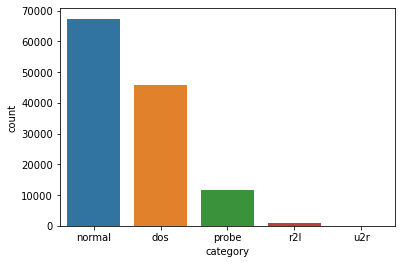

In [25]:
display_categories(train_set)

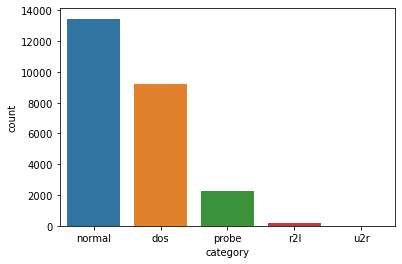

In [26]:
display_categories(train_set_20)

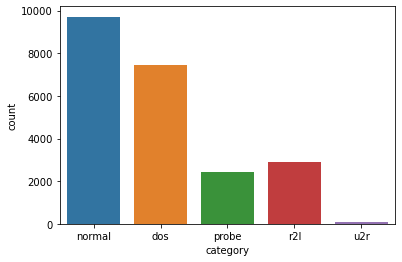

In [27]:
display_categories(test_set)

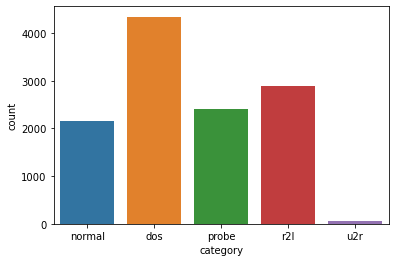

In [28]:
display_categories(test_set_21)

The distribution of records appear to be very imbalanced, especially in case of U2R attacks.

### Adding labels for binary classification

In [29]:
def binary_labels(str):
    if str in ['dos', 'r2l', 'probe', 'u2r']:
        return 'attack'
    else:
        return 'normal'
       
def add_binary_labels(df):
    df['traffic_type'] = np.vectorize(binary_labels)(df['category'])
    
def display_traffic_type(df):
    order = ['normal', 'attack']
    sns.countplot(x=df['traffic_type'], data = df, order=order);

In [30]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    add_binary_labels(df)

Binary labels were added.

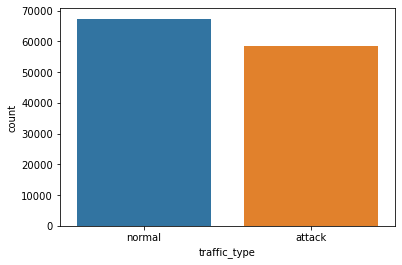

In [31]:
display_traffic_type(train_set)

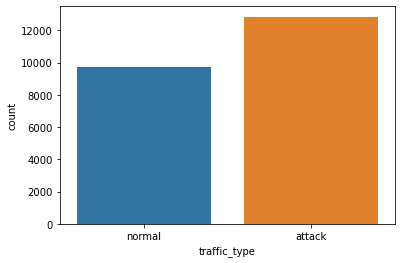

In [32]:
display_traffic_type(test_set)

## 2. Feature Encoding

### Label Encoder

In [33]:
from sklearn.preprocessing import LabelEncoder

def label_encode(df, cols):
    le = LabelEncoder()
    df[cols] = df[cols].apply(le.fit_transform)
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    return mapping

### One-hot Encoder

In [34]:
def hot_encode(df, categorical_columns = ['protocol_type', 'service', 'flag']):
    return pd.get_dummies(data=df, columns=categorical_columns, dtype='int8')

## 3. Normalization

In [35]:
from sklearn.preprocessing import MinMaxScaler

excl_cols = ['protocol_type', 'service', 'flag', 'category', 'traffic_type', 'attack_type', 'classifiers',
        'land', 'logged_in', 'is_host_login', 'is_guest_login']

def min_max_norm(df):
    scaler = MinMaxScaler()
    norm_cols = np.setdiff1d(df.columns, excl_cols)
    df[norm_cols] = scaler.fit_transform(df[norm_cols])

# Data Preparation

In [36]:
def split(df, col):
    r = pd.DataFrame(df[col])
    df.drop(col, axis = 1, inplace = True)
    return r

In [37]:
def prep_4_class(df, add = True, without = False):
    n = df.copy()
    min_max_norm(n)
    
    if(without):
        attacks = train_set['attack_type'].unique()
        new_attacks = np.setdiff1d(n['attack_type'].unique(), attacks)

        for a in new_attacks:
            rows = n[n['attack_type'] == a]
            n.drop(rows.index, axis=0, inplace=True)
    if(add):
        n = add_missing_cols(n)
    
    h = hot_encode(n)
    l5 = pd.DataFrame(h['category'])
    lm5 = label_encode(l5, ['category'])
    
    r = h[h['category'] == 'normal']
    h.drop(r.index, axis = 0, inplace = True)
    
    l = split(h, ['category'])
    remove_labels(h, ['attack_type', 'traffic_type'])
    lh = hot_encode(l, ['category'])
    lm = label_encode(l, ['category'])
    return (h, lh, lm, l, lm5, l5)  #hot encoded set, hot encoded labels, label encoding mapping, original labels

In [38]:
def prep_2_class(df, add = True):
    n = df.copy()
    min_max_norm(n)
    
    if(add):
        n = add_missing_cols(n)
        
    h = hot_encode(n)
    l = split(h, ['traffic_type'])
    remove_labels(h, ['attack_type', 'category'])
    lh = hot_encode(l, ['traffic_type'])
    lm = label_encode(l, ['traffic_type'])
    return (h, lh, lm, l)

#### Splitting KDDTrain+ dataset:

In [39]:
X_train, y_train, train_label_mapping, train_labels = prep_2_class(train_set, False)

In [40]:
X_train4, y_train4, train_label_mapping4, train_labels4, train_label_mapping5, train_labels5 = prep_4_class(train_set, False)

#### Splitting KDDTest+ dataset:

In [41]:
X_test, y_test, test_label_mapping, test_labels = prep_2_class(test_set)

In [42]:
X_test4, y_test4, test_label_mapping4, test_labels4, test_label_mapping5, test_labels5  = prep_4_class(test_set)

In [43]:
X_test_w, y_test_w, test_label_mapping_w, test_labels_w, test_label_mapping_w5, test_labels_w5  = prep_4_class(test_set, without = True)

#### Splitting KDDTest -21 dataset:

In [44]:
X_test_21, y_test_21, test_21_label_mapping, test_21_labels = prep_2_class(test_set_21)

In [45]:
X_test_214, y_test_214, test_21_label_mapping4, test_21_labels4, test_21_label_mapping5, test_21_labels5 = prep_4_class(test_set_21)

In [46]:
X_test_21_w, y_test_21_w, test_21_label_mapping_w, test_21_labels_w, test_21_label_mapping_w5, test_21_labels_w5 = prep_4_class(test_set_21, without = True)

# XGBoost

**The parameters for the XGBoost model were chosen using randomized grid search**

**clf.best_params_**

{'reg_lambda': 0.5,
 'reg_alpha': 1,
 'learning_rate': 0.1,
 'importance_type': 'weight',
 'gamma': 0.1,
 'base_score': 0.5}

### Training for 2-class classification

In [47]:
booster = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 100, use_label_encoder = False,
                          base_score =  0.5, reg_lambda = 0.5, reg_alpha = 1,  learning_rate = 0.1, 
                          importance_type = 'weight', eval_metric = 'logloss',
                          gamma = 0.1, random_state = 42)

booster.fit(X_train, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0.1, gpu_id=-1, importance_type='weight',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=1, reg_lambda=0.5,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [48]:
def metrics_binary(y, pred):
    print('\nOverall accuracy: {:.2f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, target_names=['attack', 'normal']))
    
    confusion = confusion_matrix(y, pred)
    acc = confusion.diagonal() * 100 / confusion.sum(axis=1)
    print('\nAccuracy per Class:\n\nattack\t {:.2f}'.format(acc[0]))
    print('normal\t {:.2f}'.format(acc[1]))

## Binary Classification Results

### KDDTrain+

In [49]:
yhat_train_binary = booster.predict(X_train)
cm_train_binary = tf.math.confusion_matrix(labels = train_labels, predictions = yhat_train_binary)

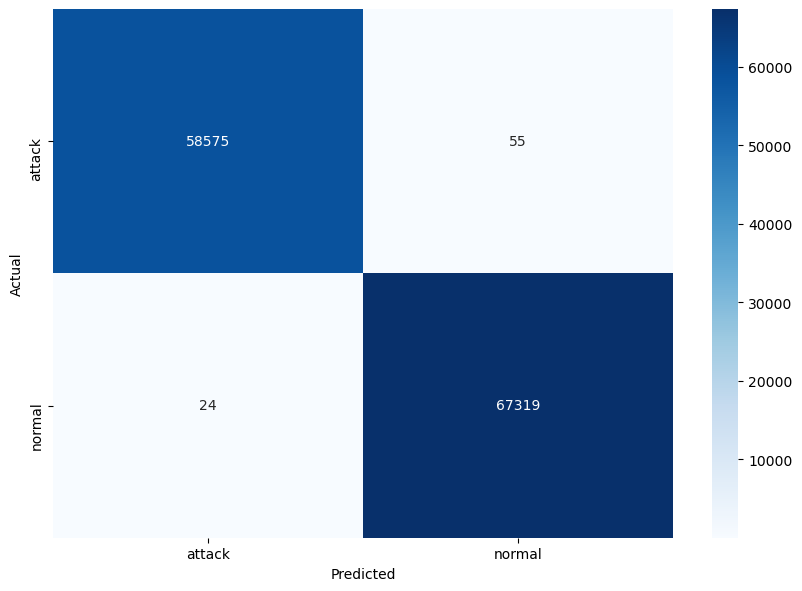

In [50]:
plt.figure(figsize =(10,7), dpi = 100)
sns.heatmap(cm_train_binary, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_label_mapping.keys(),
           yticklabels = train_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [51]:
metrics_binary(train_labels, yhat_train_binary)


Overall accuracy: 1.00


Classification report

              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     58630
      normal       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
   macro avg       1.00      1.00      1.00    125973
weighted avg       1.00      1.00      1.00    125973


Accuracy per Class:

attack	 99.91
normal	 99.96


### KDDTest+

In [52]:
yhat_test_binary = booster.predict(X_test)
cm_test_binary = tf.math.confusion_matrix(labels = test_labels, predictions = yhat_test_binary)

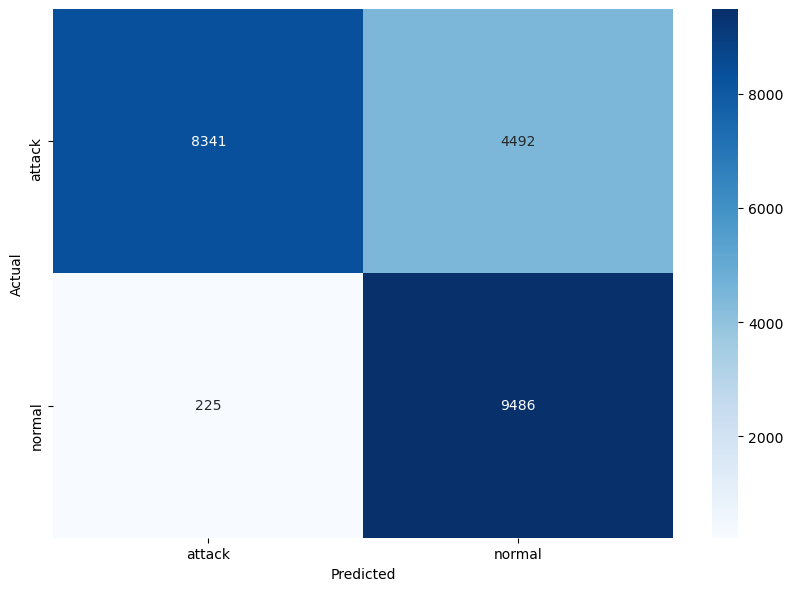

In [53]:
plt.figure(figsize =(10,7), dpi = 100)
sns.heatmap(cm_test_binary, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping.keys(),
           yticklabels = test_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [54]:
metrics_binary(test_labels, yhat_test_binary)


Overall accuracy: 0.79


Classification report

              precision    recall  f1-score   support

      attack       0.97      0.65      0.78     12833
      normal       0.68      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.83      0.81      0.79     22544
weighted avg       0.85      0.79      0.79     22544


Accuracy per Class:

attack	 65.00
normal	 97.68


### KDDTest -21

In [55]:
yhat_test_21_binary = booster.predict(X_test_21)
cm_test_21_binary = tf.math.confusion_matrix(labels = test_21_labels, predictions = yhat_test_21_binary)

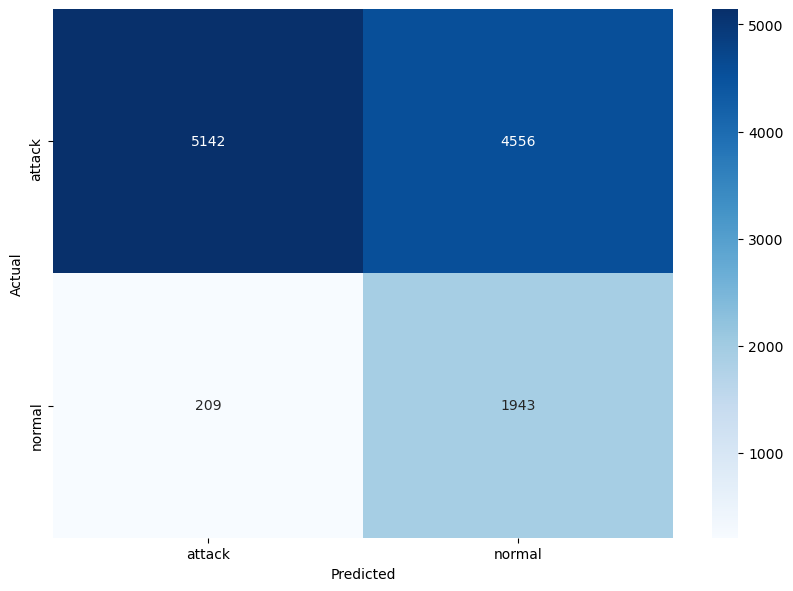

In [56]:
plt.figure(figsize =(10,7), dpi = 100)
sns.heatmap(cm_test_21_binary, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_21_label_mapping.keys(),
           yticklabels = test_21_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [57]:
metrics_binary(test_21_labels, yhat_test_21_binary)


Overall accuracy: 0.60


Classification report

              precision    recall  f1-score   support

      attack       0.96      0.53      0.68      9698
      normal       0.30      0.90      0.45      2152

    accuracy                           0.60     11850
   macro avg       0.63      0.72      0.57     11850
weighted avg       0.84      0.60      0.64     11850


Accuracy per Class:

attack	 53.02
normal	 90.29


# Autoencoder and DNN

Random generators are seeded for the purpose of obtaining reproducible results. However, due to the inherent randomness of neural networks, this approach was not completely effective.

In [58]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

### Training for 4-class classification

## Deep Autoencoder

In [59]:
encoder = keras.models.Sequential(name = 'encoder')                 
encoder.add(keras.layers.Dense(100, activation = 'relu', input_shape = (121, ), kernel_initializer = 'he_uniform'))
encoder.add(keras.layers.Dense(20, activation = 'relu', kernel_initializer = 'he_uniform'))

decoder = keras.models.Sequential(name = 'decoder')
decoder.add(keras.layers.Dense(100, activation='relu', input_shape = (20, ), kernel_initializer = 'he_uniform')) 
decoder.add(keras.layers.Dense(121, activation='sigmoid', kernel_initializer = 'he_uniform'))

deep_ae = keras.models.Sequential([
    encoder,
    decoder
])

deep_ae.compile(
    loss = 'binary_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=0.01)
)

deep_ae_history = deep_ae.fit(X_train4, X_train4, batch_size= 256, epochs=30)

Epoch 1/30
230/230 [==============================] - 1s 2ms/step - loss: 0.0460
Epoch 2/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 3/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 4/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 5/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 6/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 7/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 8/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 9/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 10/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 11/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 12/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 13/30
230/230 [====

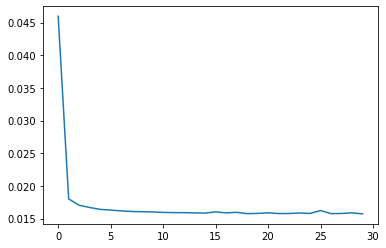

In [60]:
plt.plot(deep_ae_history.history['loss']);

In [61]:
encoder_layers = deep_ae.get_layer('encoder')
encoder_layers.trainable = False

dnn = keras.models.Sequential([ 
    encoder_layers,
    keras.layers.Dense(4, input_shape=(20, ), activation = 'softmax', kernel_initializer = 'he_uniform')
])

dnn.compile(
    loss = 'binary_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
              
)

dnn_history = dnn.fit(X_train4, y_train4, batch_size= 256, epochs = 50)

Epoch 1/50
230/230 [==============================] - 1s 795us/step - loss: 0.1408 - accuracy: 0.9208 - precision: 0.9242 - recall: 0.9183
Epoch 2/50
230/230 [==============================] - 0s 775us/step - loss: 0.0437 - accuracy: 0.9771 - precision: 0.9783 - recall: 0.9760
Epoch 3/50
230/230 [==============================] - 0s 971us/step - loss: 0.0304 - accuracy: 0.9849 - precision: 0.9851 - recall: 0.9846
Epoch 4/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9881 - precision: 0.9884 - recall: 0.9878
Epoch 5/50
230/230 [==============================] - 0s 884us/step - loss: 0.0235 - accuracy: 0.9896 - precision: 0.9899 - recall: 0.9893
Epoch 6/50
230/230 [==============================] - 0s 761us/step - loss: 0.0223 - accuracy: 0.9898 - precision: 0.9900 - recall: 0.9895
Epoch 7/50
230/230 [==============================] - 0s 1ms/step - loss: 0.0214 - accuracy: 0.9900 - precision: 0.9903 - recall: 0.9897
Epoch 8/50
230/230 [===========

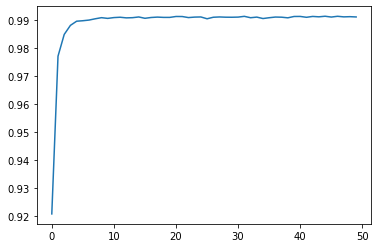

In [62]:
plt.plot(dnn_history.history['accuracy']);

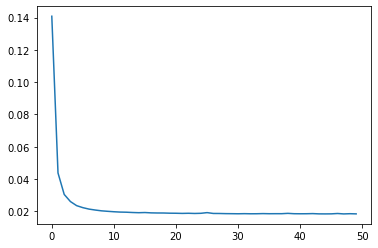

In [63]:
plt.plot(dnn_history.history['loss']);

# Multi-Class classification results

**Previously saved weights that produced the best results**

In [64]:
dnn.load_weights('best results weights.h5')

### Original Data

In [65]:
def metrics(y, pred):
    print('\nOverall accuracy: {:.2f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, target_names=['dos', 'probe', 'r2l', 'u2r']))
    
    confusion = confusion_matrix(y, pred)
    acc = confusion.diagonal() * 100 / confusion.sum(axis=1)
    print('\nAccuracy per Class:\n\ndos\t {:.2f}'.format(acc[0]))
    print('probe\t {:.2f}'.format(acc[1]))
    print('r2l\t {:.2f}'.format(acc[2]))
    print('u2r\t {:.2f}'.format(acc[3]))

In [66]:
yhat_train = dnn.predict(X_train4)
yhat_train_labels = [np.argmax(i) for i in yhat_train]
cm_train = tf.math.confusion_matrix(labels = train_labels4, 
                               predictions = yhat_train_labels)

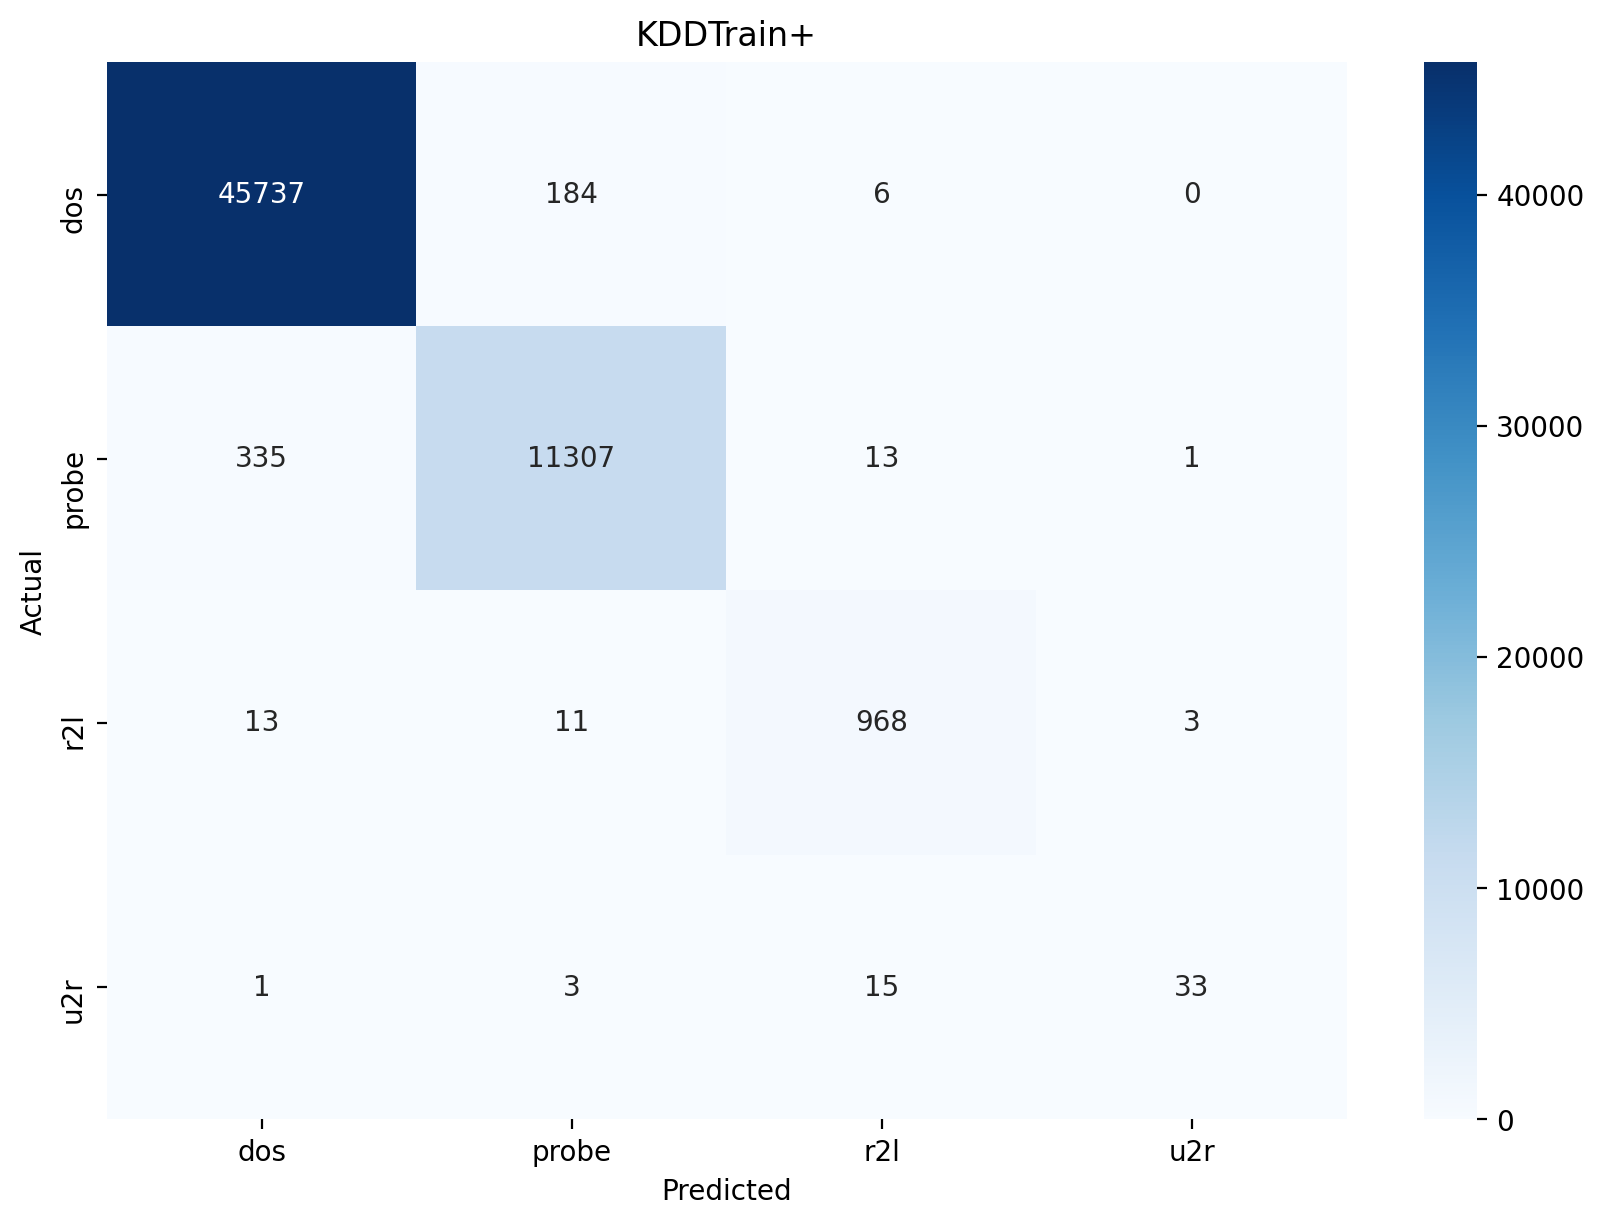

In [67]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTrain+')
sns.heatmap(cm_train, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_label_mapping4.keys(),
           yticklabels = train_label_mapping4.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [68]:
metrics(train_labels4, yhat_train_labels)


Overall accuracy: 0.99


Classification report

              precision    recall  f1-score   support

         dos       0.99      1.00      0.99     45927
       probe       0.98      0.97      0.98     11656
         r2l       0.97      0.97      0.97       995
         u2r       0.89      0.63      0.74        52

    accuracy                           0.99     58630
   macro avg       0.96      0.89      0.92     58630
weighted avg       0.99      0.99      0.99     58630


Accuracy per Class:

dos	 99.59
probe	 97.01
r2l	 97.29
u2r	 63.46


In [69]:
yhat_test = dnn.predict(X_test4)
yhat_test_labels = [np.argmax(i) for i in yhat_test]
cm_test = tf.math.confusion_matrix(labels = test_labels4, 
                              predictions = yhat_test_labels)

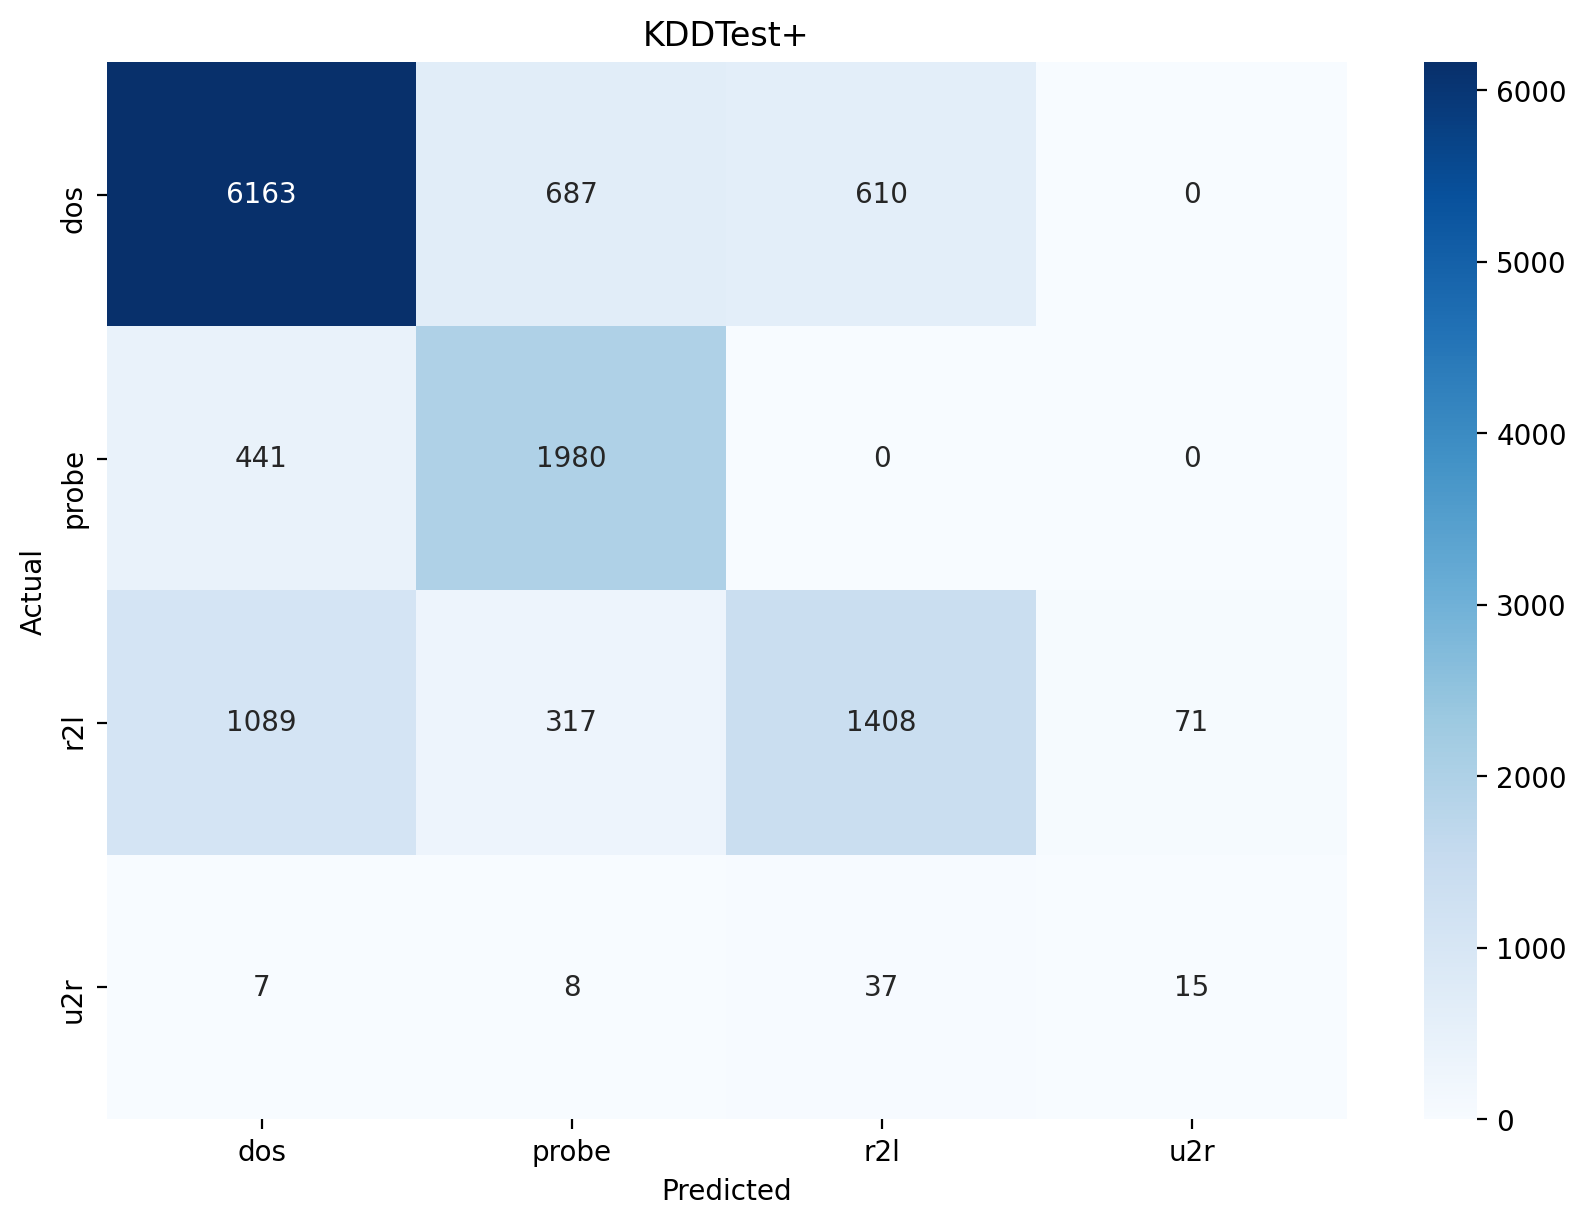

In [70]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest+')
sns.heatmap(cm_test, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping4.keys(),
           yticklabels = test_label_mapping4.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [71]:
metrics(test_labels4, yhat_test_labels)


Overall accuracy: 0.75


Classification report

              precision    recall  f1-score   support

         dos       0.80      0.83      0.81      7460
       probe       0.66      0.82      0.73      2421
         r2l       0.69      0.49      0.57      2885
         u2r       0.17      0.22      0.20        67

    accuracy                           0.75     12833
   macro avg       0.58      0.59      0.58     12833
weighted avg       0.75      0.75      0.74     12833


Accuracy per Class:

dos	 82.61
probe	 81.78
r2l	 48.80
u2r	 22.39


In [72]:
yhat_test_w = dnn.predict(X_test_w)
yhat_test_labels_w = [np.argmax(i) for i in yhat_test_w]
cm_test_w = tf.math.confusion_matrix(labels = test_labels_w, 
                              predictions = yhat_test_labels_w)

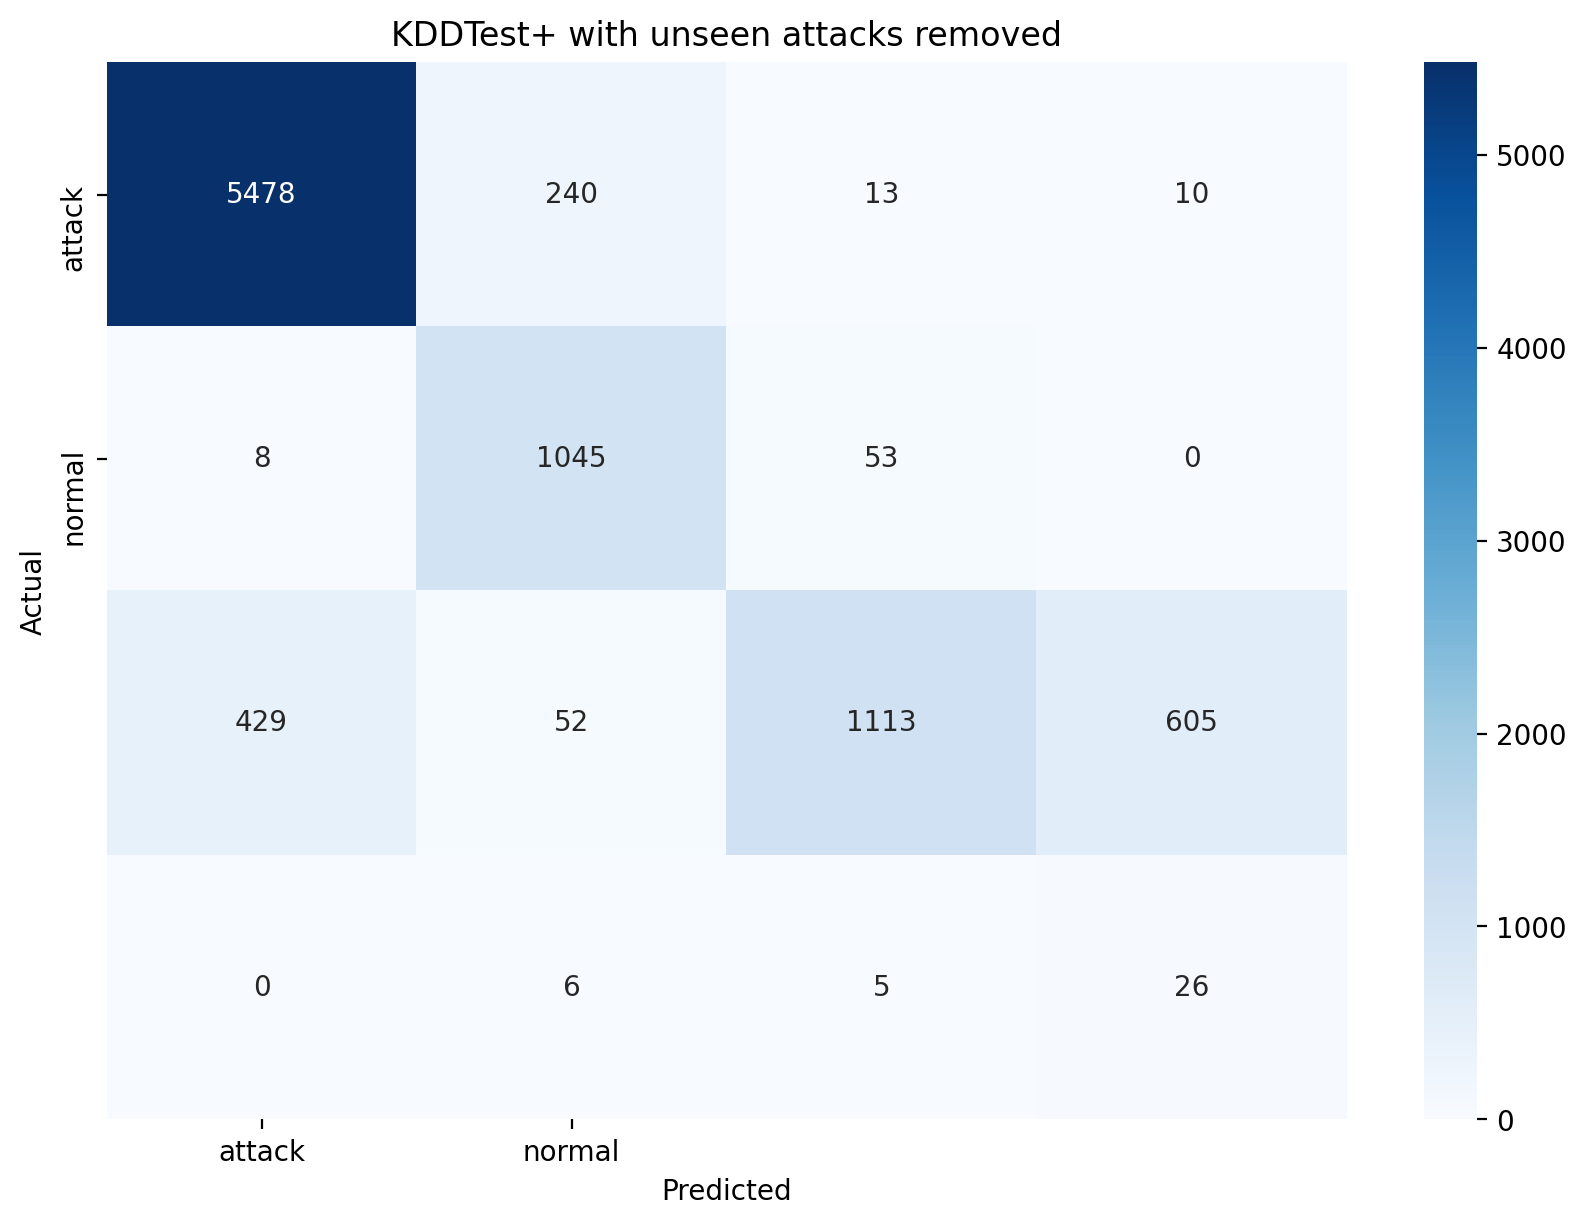

In [73]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest+ with unseen attacks removed')
sns.heatmap(cm_test_w, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping.keys(),
           yticklabels = test_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [74]:
metrics(test_labels_w, yhat_test_labels_w)


Overall accuracy: 0.84


Classification report

              precision    recall  f1-score   support

         dos       0.93      0.95      0.94      5741
       probe       0.78      0.94      0.85      1106
         r2l       0.94      0.51      0.66      2199
         u2r       0.04      0.70      0.08        37

    accuracy                           0.84      9083
   macro avg       0.67      0.78      0.63      9083
weighted avg       0.91      0.84      0.86      9083


Accuracy per Class:

dos	 95.42
probe	 94.48
r2l	 50.61
u2r	 70.27


In [75]:
yhat_21 = dnn.predict(X_test_214)
yhat_21_labels = [np.argmax(i) for i in yhat_21]
cm_21 = tf.math.confusion_matrix(labels = test_21_labels4, 
                                 predictions = yhat_21_labels)

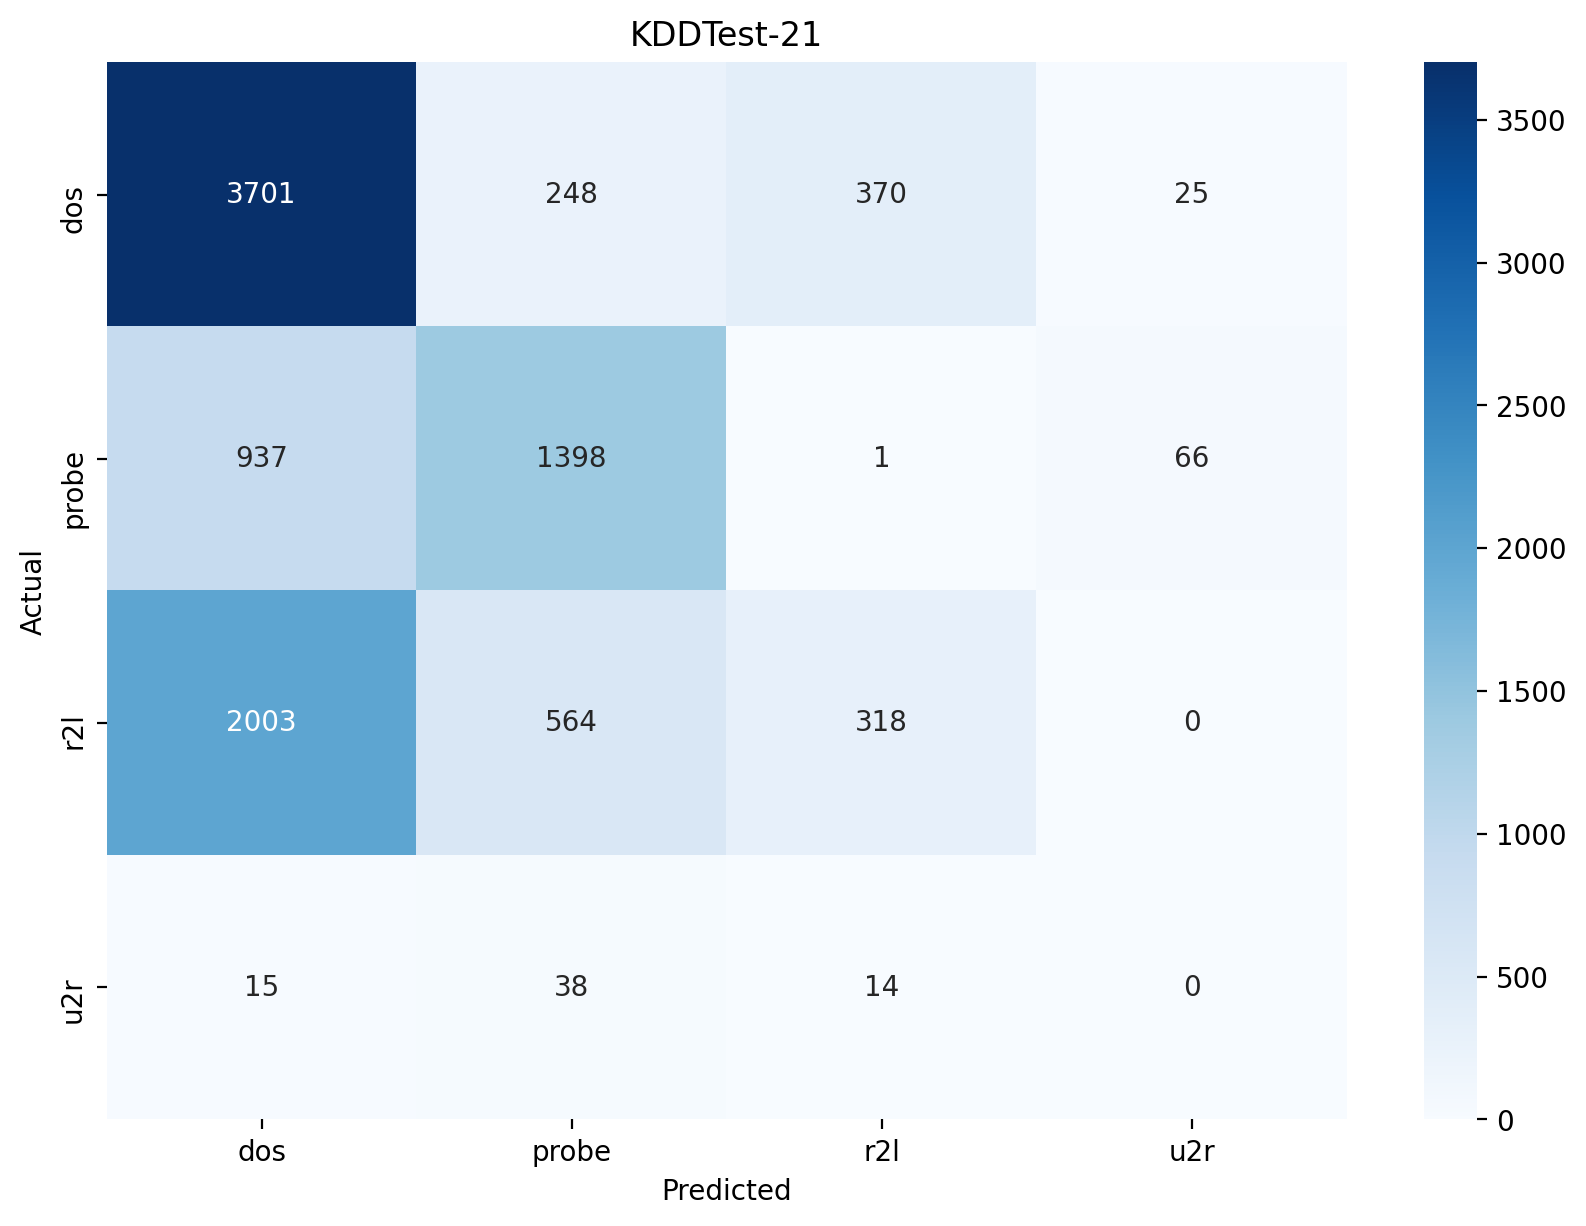

In [76]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest-21')
sns.heatmap(cm_21, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_21_label_mapping4.keys(),
           yticklabels = test_21_label_mapping4.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [77]:
metrics(test_21_labels4, yhat_21_labels)


Overall accuracy: 0.56


Classification report

              precision    recall  f1-score   support

         dos       0.56      0.85      0.67      4344
       probe       0.62      0.58      0.60      2402
         r2l       0.45      0.11      0.18      2885
         u2r       0.00      0.00      0.00        67

    accuracy                           0.56      9698
   macro avg       0.41      0.39      0.36      9698
weighted avg       0.54      0.56      0.50      9698


Accuracy per Class:

dos	 85.20
probe	 58.20
r2l	 11.02
u2r	 0.00


In [78]:
yhat_21_w = dnn.predict(X_test_21_w)
yhat_21_labels_w = [np.argmax(i) for i in yhat_21_w]
cm_21_w = tf.math.confusion_matrix(labels = test_21_labels_w, 
                                 predictions = yhat_21_labels_w)

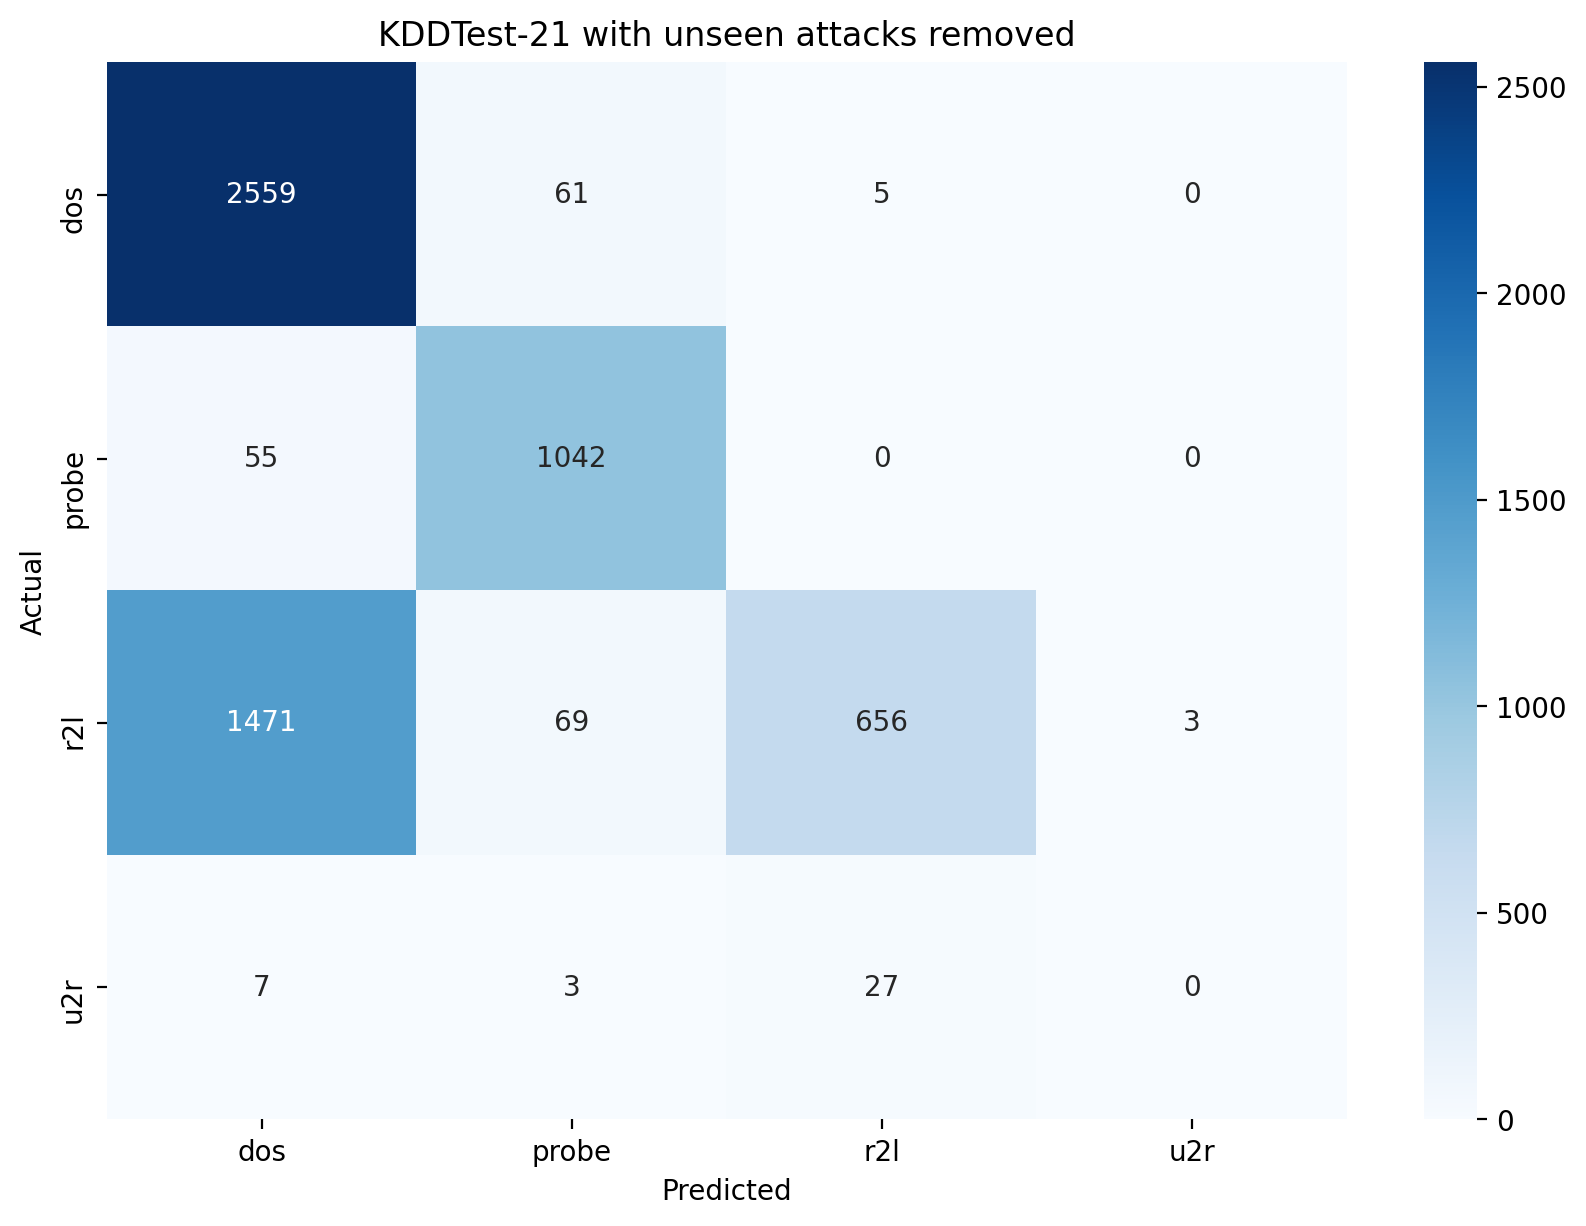

In [79]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest-21 with unseen attacks removed')
sns.heatmap(cm_21_w, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_21_label_mapping_w.keys(),
           yticklabels = test_21_label_mapping_w.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [80]:
metrics(test_21_labels_w, yhat_21_labels_w)


Overall accuracy: 0.71


Classification report

              precision    recall  f1-score   support

         dos       0.63      0.97      0.76      2625
       probe       0.89      0.95      0.92      1097
         r2l       0.95      0.30      0.45      2199
         u2r       0.00      0.00      0.00        37

    accuracy                           0.71      5958
   macro avg       0.62      0.56      0.53      5958
weighted avg       0.79      0.71      0.67      5958


Accuracy per Class:

dos	 97.49
probe	 94.99
r2l	 29.83
u2r	 0.00


### Predictions from XGBoost Model

In [81]:
def metrics5(y, pred):
    print('\nOverall accuracy: {:.2f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, target_names=['dos', 'normal', 'probe', 'r2l', 'u2r']))
    
    confusion = confusion_matrix(y, pred)
    acc = confusion.diagonal() * 100 / confusion.sum(axis=1)
    print('\nAccuracy per Class:\n\ndos\t {:.2f}'.format(acc[0]))
    print('probe\t {:.2f}'.format(acc[2]))
    print('r2l\t {:.2f}'.format(acc[3]))
    print('u2r\t {:.2f}'.format(acc[4]))

In [82]:
def realign_pred(p):
    return [x+1 if x != 0 else 0 for x in p]

### KDDTest+

In [83]:
train_label_mapping

{'attack': 0, 'normal': 1}

In [84]:
train_label_mapping5

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

In [85]:
i_train = yhat_train_binary.copy()

In [86]:
pd.DataFrame(i_train).value_counts()

1    67374
0    58599
dtype: int64

In [87]:
i_train4 = [i for i, p in enumerate(i_train) if p == 0]
X_train_b = X_train.iloc[i_train4]
train_labels_b = train_labels5.iloc[i_train4]

In [88]:
yhat_train_b = dnn.predict(X_train_b)
yhat_train_labels_b = [np.argmax(i) for i in yhat_train_b]
yhat_train_labels_b_ = realign_pred(yhat_train_labels_b)
cm_train_b = tf.math.confusion_matrix(labels = train_labels_b, 
                               predictions = yhat_train_labels_b_)

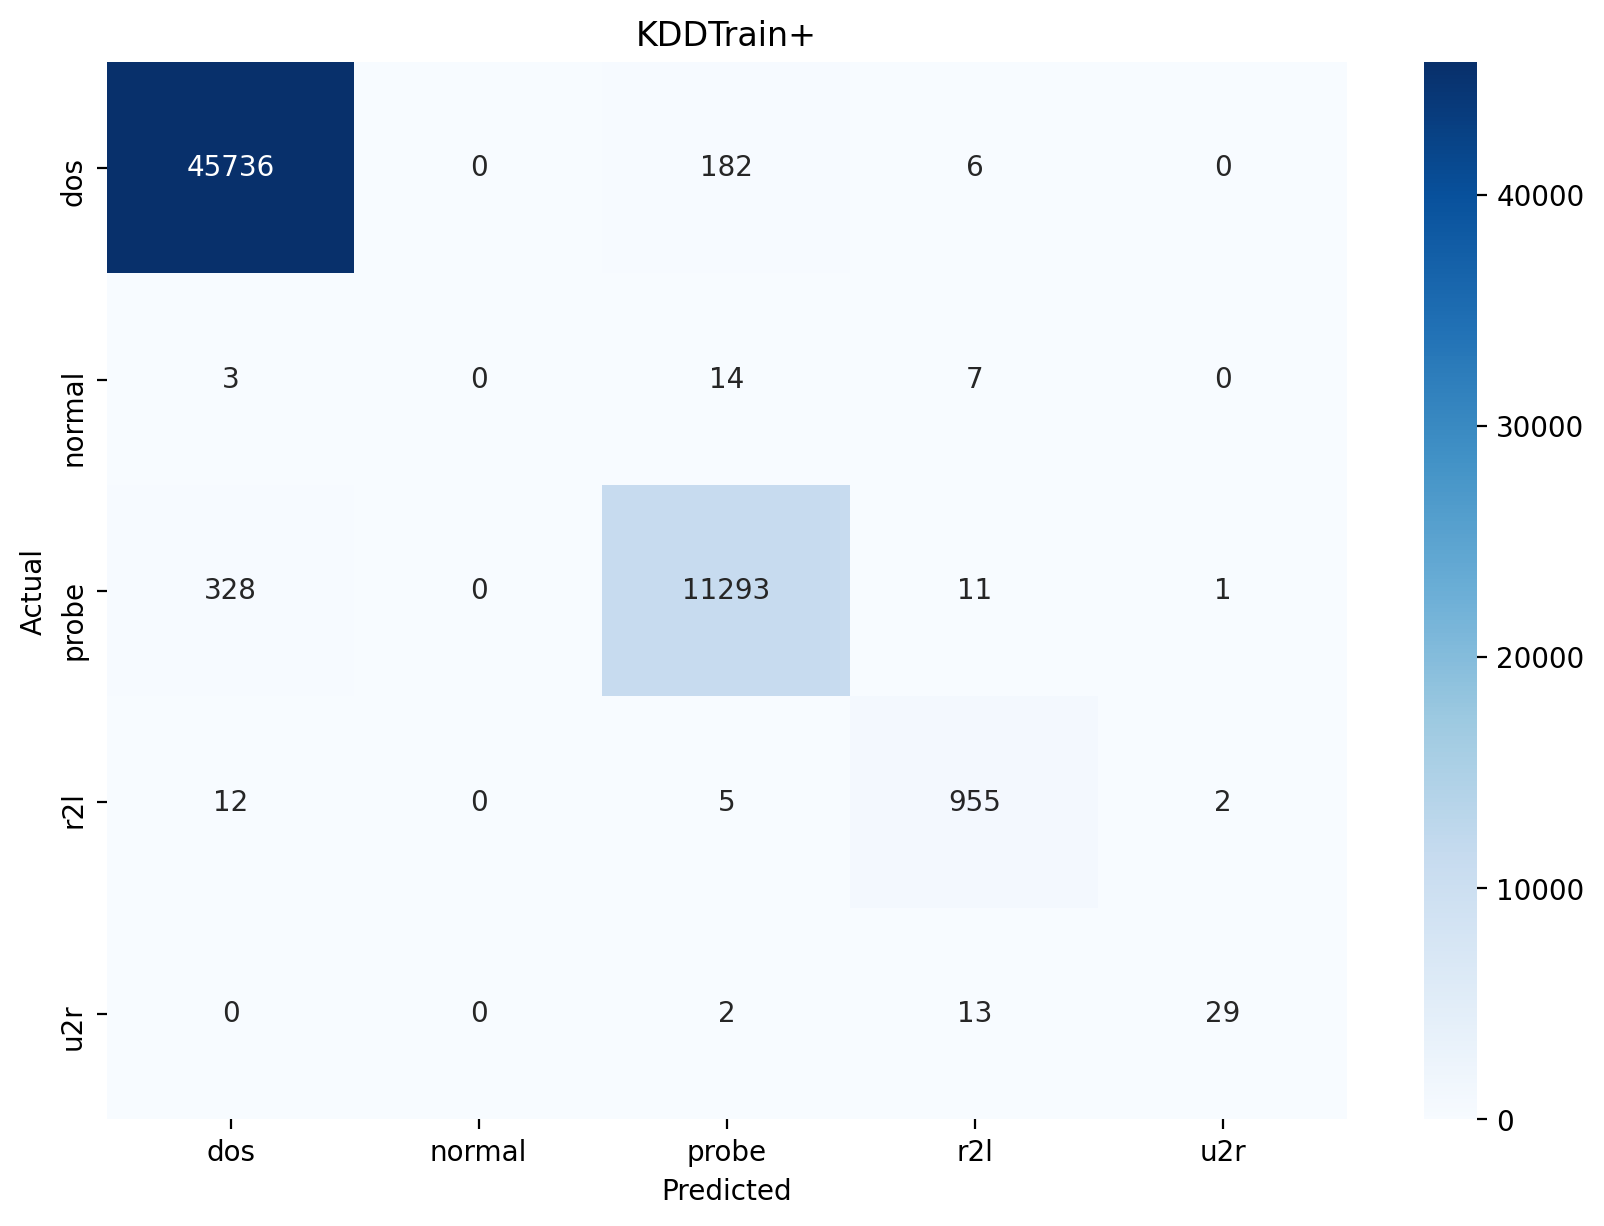

In [89]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTrain+')
sns.heatmap(cm_train_b, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_label_mapping5.keys(),
           yticklabels = train_label_mapping5.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [108]:
metrics5(train_labels_b, yhat_train_labels_b_)


Overall accuracy: 0.99


Classification report

              precision    recall  f1-score   support

         dos       0.99      1.00      0.99     45924
      normal       0.00      0.00      0.00        24
       probe       0.98      0.97      0.98     11633
         r2l       0.96      0.98      0.97       974
         u2r       0.91      0.66      0.76        44

    accuracy                           0.99     58599
   macro avg       0.77      0.72      0.74     58599
weighted avg       0.99      0.99      0.99     58599


Accuracy per Class:

dos	 99.59
probe	 97.08
r2l	 98.05
u2r	 65.91


### KDDTest+

In [91]:
test_label_mapping

{'attack': 0, 'normal': 1}

In [92]:
test_label_mapping5

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

In [93]:
i_test = yhat_test_binary.copy()

In [94]:
pd.DataFrame(i_test).value_counts()

1    13978
0     8566
dtype: int64

In [95]:
i_test4 = [i for i, p in enumerate(i_test) if p == 0]
X_test_b = X_test.iloc[i_test4]
test_labels_b = test_labels5.iloc[i_test4]

In [96]:
yhat_test_b = dnn.predict(X_test_b)
yhat_test_labels_b = [np.argmax(i) for i in yhat_test_b]
yhat_test_labels_b_ = realign_pred(yhat_test_labels_b)
cm_test_b = tf.math.confusion_matrix(labels = test_labels_b, 
                               predictions = yhat_test_labels_b_)

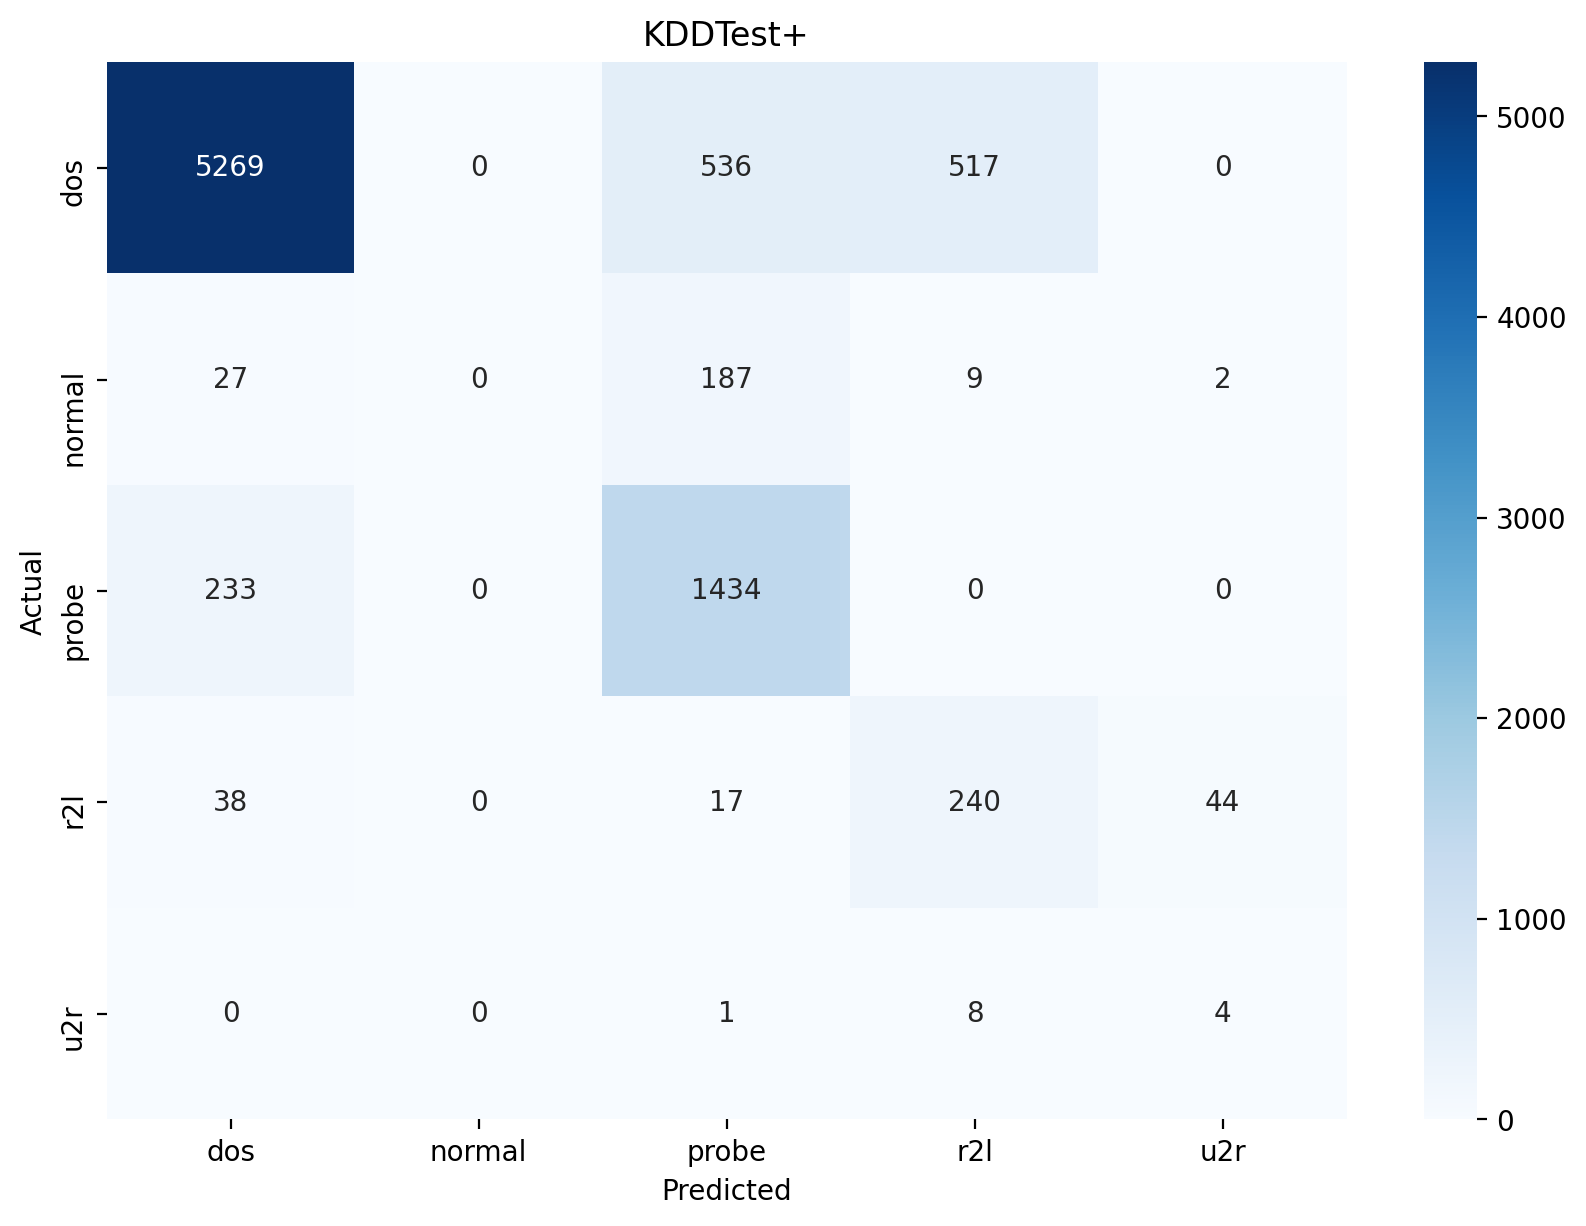

In [97]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest+')
sns.heatmap(cm_test_b, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping5.keys(),
           yticklabels = test_label_mapping5.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [107]:
metrics5(test_labels_b, yhat_test_labels_b_)


Overall accuracy: 0.81


Classification report

              precision    recall  f1-score   support

         dos       0.95      0.83      0.89      6322
      normal       0.00      0.00      0.00       225
       probe       0.66      0.86      0.75      1667
         r2l       0.31      0.71      0.43       339
         u2r       0.08      0.31      0.13        13

    accuracy                           0.81      8566
   macro avg       0.40      0.54      0.44      8566
weighted avg       0.84      0.81      0.82      8566


Accuracy per Class:

dos	 83.34
probe	 86.02
r2l	 70.80
u2r	 30.77


### KDDTest -21

In [99]:
test_21_label_mapping

{'attack': 0, 'normal': 1}

In [100]:
test_21_label_mapping5

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

In [101]:
i_test_21 = yhat_test_21_binary.copy()

In [102]:
pd.DataFrame(i_test_21).value_counts()

1    6499
0    5351
dtype: int64

In [103]:
i_test_214 = [i for i, p in enumerate(i_test_21) if p == 0]
X_test_21_b = X_test_21.iloc[i_test_214]
test_21_labels_b = test_21_labels5.iloc[i_test_214]

In [104]:
yhat_test_21_b = dnn.predict(X_test_21_b)
yhat_test_21_labels_b = [np.argmax(i) for i in yhat_test_21_b]
yhat_test_21_labels_b_ = realign_pred(yhat_test_21_labels_b)
cm_test_21_b = tf.math.confusion_matrix(labels = test_21_labels_b, 
                               predictions = yhat_test_21_labels_b_)

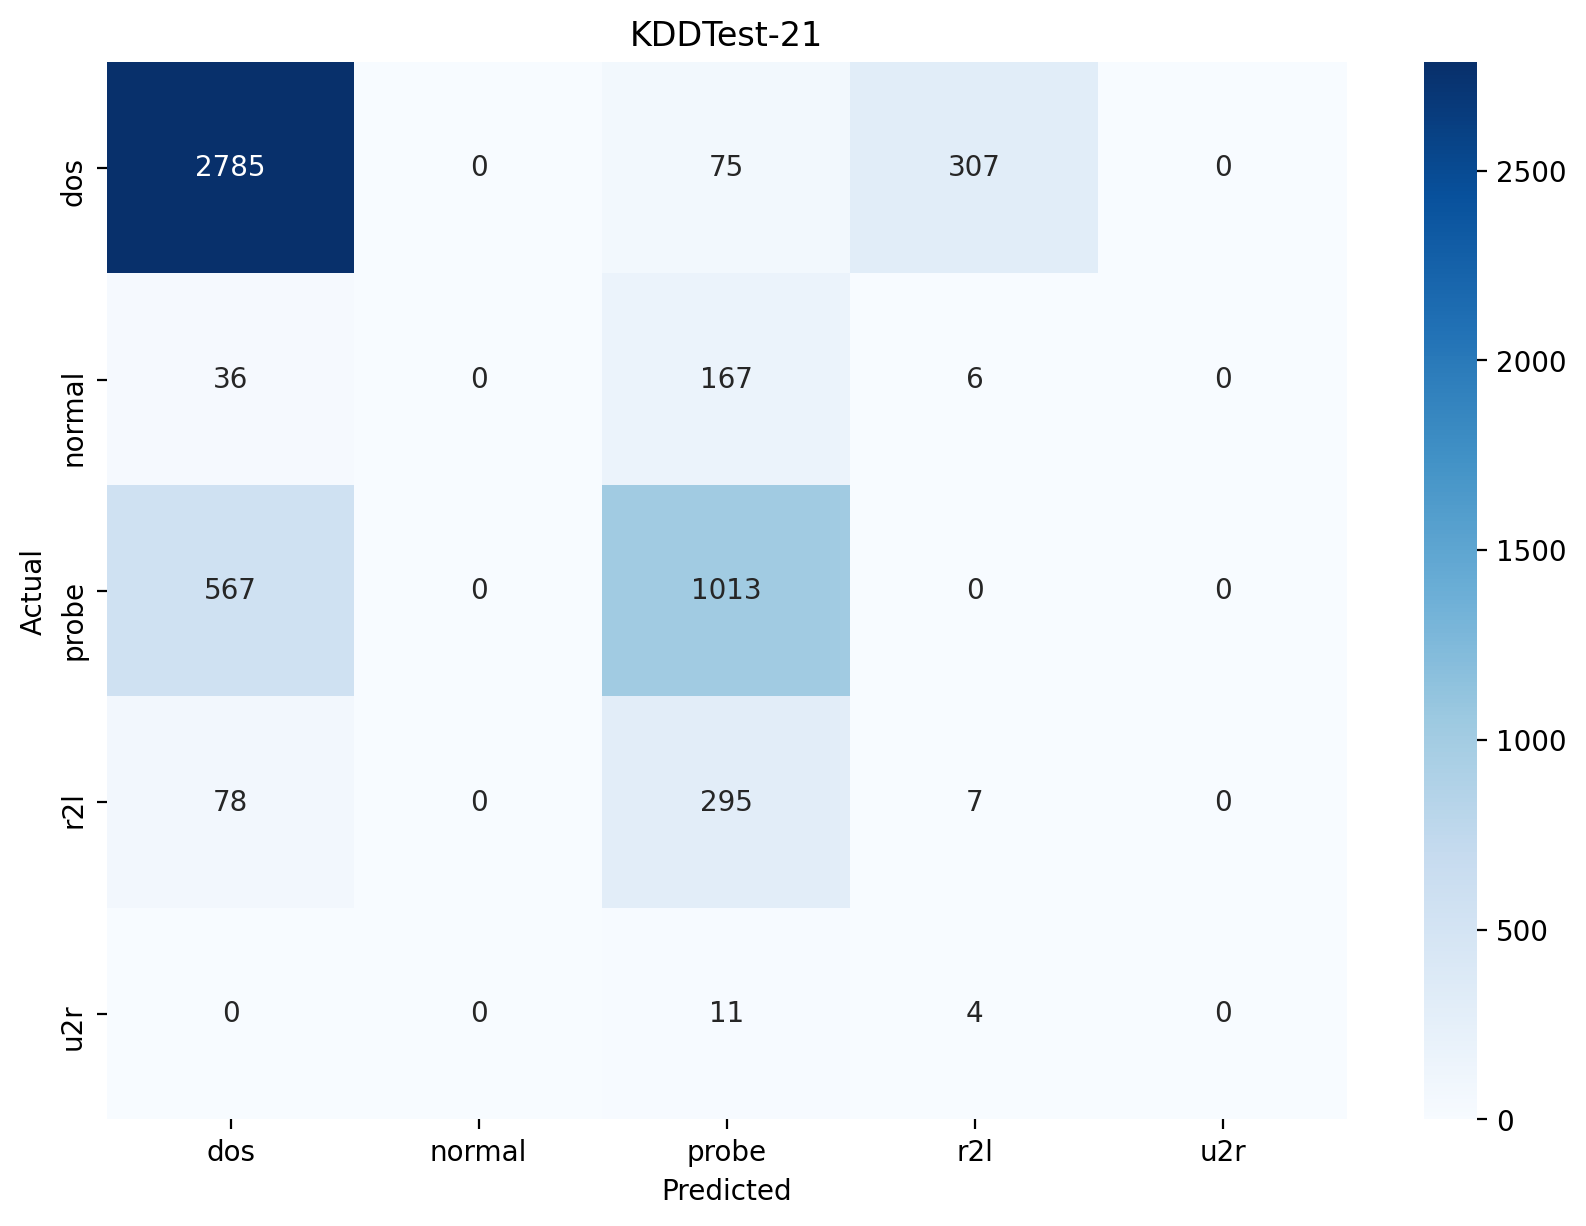

In [105]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest-21')
sns.heatmap(cm_test_21_b, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_21_label_mapping5.keys(),
           yticklabels = test_21_label_mapping5.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [109]:
metrics5(test_21_labels_b, yhat_test_21_labels_b_)


Overall accuracy: 0.71


Classification report

              precision    recall  f1-score   support

         dos       0.80      0.88      0.84      3167
      normal       0.00      0.00      0.00       209
       probe       0.65      0.64      0.65      1580
         r2l       0.02      0.02      0.02       380
         u2r       0.00      0.00      0.00        15

    accuracy                           0.71      5351
   macro avg       0.29      0.31      0.30      5351
weighted avg       0.67      0.71      0.69      5351


Accuracy per Class:

dos	 87.94
probe	 64.11
r2l	 1.84
u2r	 0.00
